<a href="https://www.kaggle.com/code/hossamelsrah/cats-vs-dogs-image-classification?scriptVersionId=239563001" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# **Deep Learning Project: Cat vs Dog Image Classification**

This notebook contains an end-to-end deep learning project for binary classification
of cats and dogs using convolutional neural networks (CNNs).

# Read and Prepare our Images Dataset
> Import The Neede libraries for Prepare our Data

In [1]:
!pip install split-folders

In [2]:
# Import essential libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
import zipfile
from sklearn.model_selection import train_test_split
import splitfolders
import warnings

# Basic warnings filter
warnings.filterwarnings('ignore')

In [3]:
# Unzip dataset files (Kaggle stores them as zip files)
with zipfile.ZipFile('/kaggle/input/dogs-vs-cats/train.zip', 'r') as zip_ref:
    zip_ref.extractall('/kaggle/working/temp_train')
with zipfile.ZipFile('/kaggle/input/dogs-vs-cats/test1.zip', 'r') as zip_ref:
    zip_ref.extractall('/kaggle/working/temp_test')

# Verify extraction
print("Train files:", len(os.listdir('/kaggle/working/temp_train/train')))
print("Test files:", len(os.listdir('/kaggle/working/temp_test/test1')))

# Create organized directory structure
os.makedirs('/kaggle/working/data/train/cats', exist_ok=True)
os.makedirs('/kaggle/working/data/train/dogs', exist_ok=True)
os.makedirs('/kaggle/working/data/val/cats', exist_ok=True)
os.makedirs('/kaggle/working/data/val/dogs', exist_ok=True)

Train files: 25000
Test files: 12500


## Show Some random Samples of data

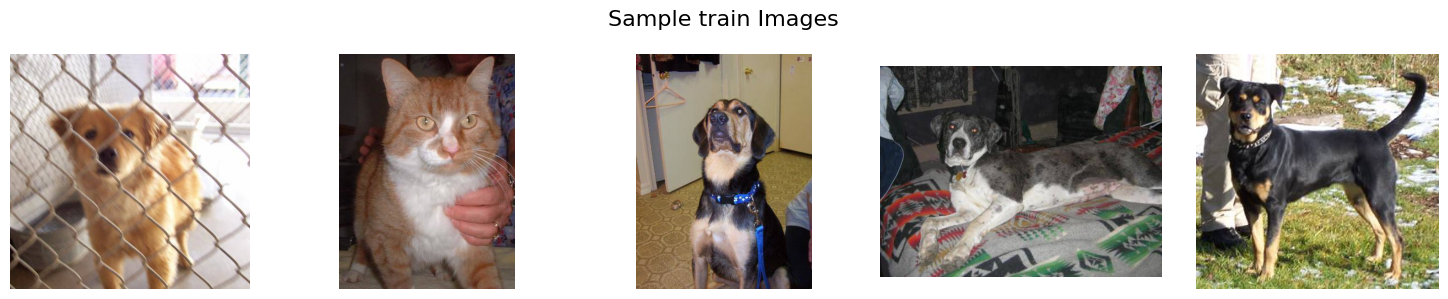

In [4]:
# Display sample images function
def display_samples(folder, num_samples=5):
    plt.figure(figsize=(15, 3))
    plt.suptitle(f"Sample {folder.split('/')[-1]} Images", fontsize=16)
    
    # Get random samples
    samples = random.sample(os.listdir(folder), num_samples)
    
    for i, img_name in enumerate(samples):
        img_path = os.path.join(folder, img_name)
        img = mpimg.imread(img_path)
        
        plt.subplot(1, num_samples, i+1)
        plt.imshow(img)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Display cat and dog samples
train_dir = '/kaggle/working/temp_train/train'
display_samples(train_dir)  # Will show mixed samples

## Splting The data & Create directory structure for organized dataset storage

In [5]:
# Organize files into class folders
for filename in os.listdir('/kaggle/working/temp_train/train'):
    src = os.path.join('/kaggle/working/temp_train/train', filename)
    
    if filename.startswith('cat'):
        dst = os.path.join('/kaggle/working/data/train/cats', filename)
    elif filename.startswith('dog'):
        dst = os.path.join('/kaggle/working/data/train/dogs', filename)
    
    os.rename(src, dst)

# Split into train/validation sets
splitfolders.ratio(
    '/kaggle/working/data/train',  # Source folder
    output='/kaggle/working/data/split',  # Output folder
    seed=42,
    ratio=(0.9, 0.1),  # Train/val ratio
    group_prefix=None
)

Copying files: 25000 files [00:03, 7077.65 files/s]


In [6]:
# Remove temporary files (optional)
!rm -r /kaggle/working/temp_train
!rm -r /kaggle/working/temp_test

## Show Some Samples from The new directory


Training Samples After Organization


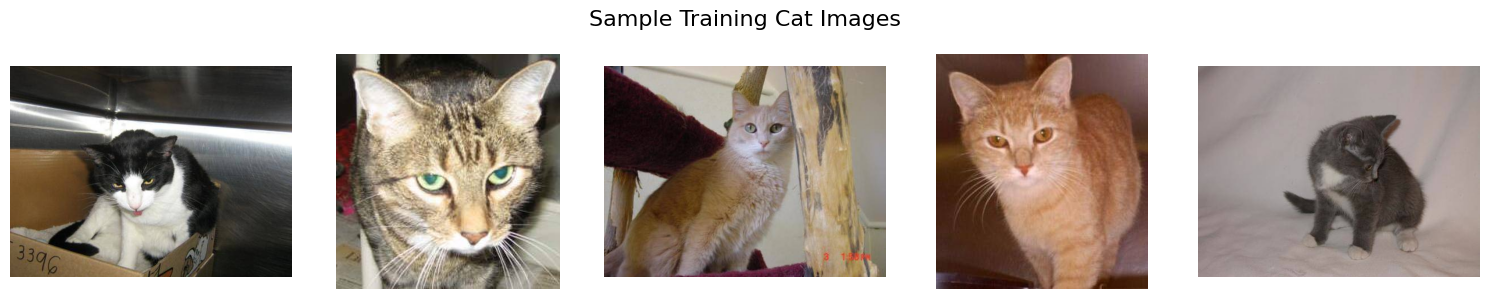

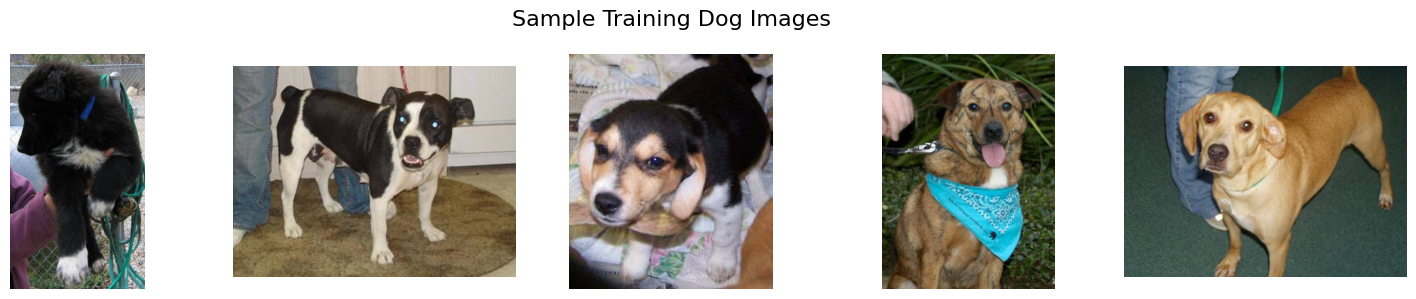


Validation Samples


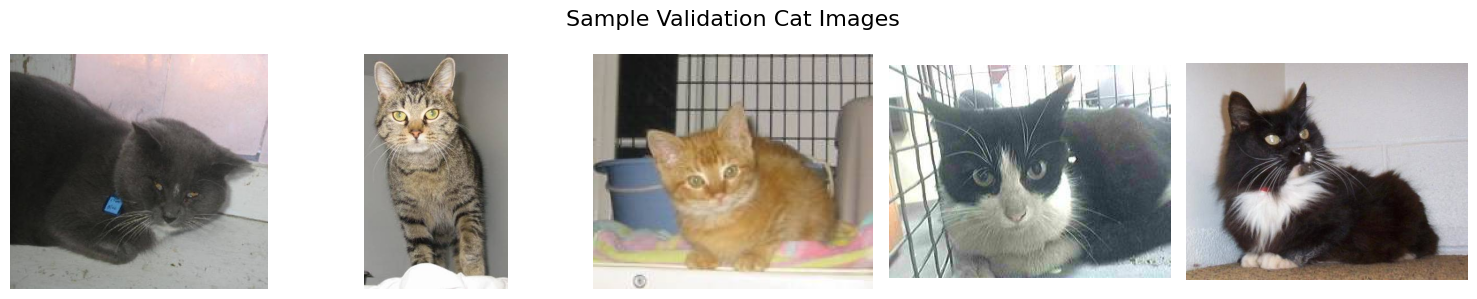

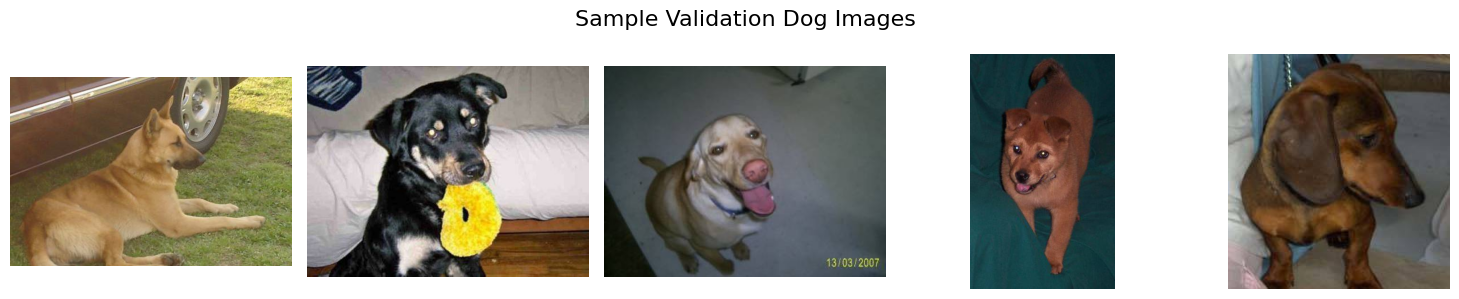


Final Counts:
Training Cats: 11250
Training Dogs: 11250
Validation Cats: 1250
Validation Dogs: 1250


In [7]:
# Display samples from the organized dataset
def display_organized_samples(folder, title, num_samples=5):
    plt.figure(figsize=(15, 3))
    plt.suptitle(title, fontsize=16)
    
    # Get random samples
    samples = random.sample(os.listdir(folder), num_samples)
    
    for i, img_name in enumerate(samples):
        img_path = os.path.join(folder, img_name)
        img = mpimg.imread(img_path)
        
        plt.subplot(1, num_samples, i+1)
        plt.imshow(img)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Display samples from each category
print("\n" + "="*50)
print("Training Samples After Organization")
print("="*50)

# Cat samples
display_organized_samples(
    '/kaggle/working/data/split/train/cats',
    "Sample Training Cat Images"
)

# Dog samples
display_organized_samples(
    '/kaggle/working/data/split/train/dogs', 
    "Sample Training Dog Images"
)

# Validation samples
print("\n" + "="*50)
print("Validation Samples")
print("="*50)

# Validation cats
display_organized_samples(
    '/kaggle/working/data/split/val/cats',
    "Sample Validation Cat Images"
)

# Validation dogs
display_organized_samples(
    '/kaggle/working/data/split/val/dogs',
    "Sample Validation Dog Images"
)

# Show counts
print("\nFinal Counts:")
print(f"Training Cats: {len(os.listdir('/kaggle/working/data/split/train/cats'))}")
print(f"Training Dogs: {len(os.listdir('/kaggle/working/data/split/train/dogs'))}")
print(f"Validation Cats: {len(os.listdir('/kaggle/working/data/split/val/cats'))}")
print(f"Validation Dogs: {len(os.listdir('/kaggle/working/data/split/val/dogs'))}")

Now After the directory organization and file movement is complete...

------

# Image Data Generator With Data Augmentation

In [8]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Identify new paths
train_dir = '/kaggle/working/data/split/train'  
val_dir = '/kaggle/working/data/split/val'      

# Training data generator with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='reflect'
)

# Validation data generator (only normalization)
val_datagen = ImageDataGenerator(rescale=1./255)

# Generate training batches from directory
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    classes=['cats', 'dogs'] 
)

# Generate validation batches from directory
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    classes=['cats', 'dogs'],
    shuffle=False
)

# Print a summary of the data
print("\nTraining Class Indices:", train_generator.class_indices)
print("Validation Class Indices:", val_generator.class_indices)

2025-05-13 20:54:58.679061: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747169698.877465      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747169698.932428      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Found 22500 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.

Training Class Indices: {'cats': 0, 'dogs': 1}
Validation Class Indices: {'cats': 0, 'dogs': 1}


In [9]:
val_generator.class_indices

{'cats': 0, 'dogs': 1}

# CNN Model

In [10]:
# Import Our Model Libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import L2
import os

# Enhanced Callbacks Configuration
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ModelCheckpoint('/kaggle/working/best_model.keras', save_best_only=True), 
    ReduceLROnPlateau(factor=0.5, patience=5)
]

# Create model 
model = Sequential([
    # Block 1
    Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(150,150,3)),
    BatchNormalization(),
    Conv2D(32, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Dropout(0.25),

    # Block 2
    Conv2D(64, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(64, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Dropout(0.25),

    # Block 3
    Conv2D(128, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(128, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Dropout(0.25),

    # Classifier
    Flatten(),
    Dense(256, activation='relu', kernel_regularizer=L2(0.01)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Load pre-trained weights if available 
os.makedirs('/kaggle/working/output', exist_ok=True)
if os.path.exists("/kaggle/working/output/weights.best.hdf5"):
    model.load_weights("/kaggle/working/output/weights.best.hdf5")
    print("Loaded pre-trained weights successfully!")

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

# Compile model 
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy',
                      tf.keras.metrics.Precision(),
                      tf.keras.metrics.Recall()])
model.summary()

I0000 00:00:1747169711.161333      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 150, 150, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 150, 150, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 150, 150, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 150, 150, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 75, 75, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 75, 75, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 75, 75, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 75, 75, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 75, 75, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 75, 75, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 37, 37, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 37, 37, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 37, 37, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 37, 37, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 37, 37, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 37, 37, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 18, 18, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 18, 18, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 10,907,169 (41.61 MB)

 Trainable params: 10,905,761 (41.60 MB)

 Non-trainable params: 1,408 (5.50 KB)

In [11]:
# Training Configuration
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator,
    callbacks=callbacks,
    verbose=1
)

# Save Final Model
model.save('/kaggle/working/output/dogs_vs_cats_model.h5')
print("Training completed and model saved in ")
!ls -lh /kaggle/working/output/

Epoch 1/50


I0000 00:00:1747169721.805421     114 service.cc:148] XLA service 0x781978009050 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747169721.806213     114 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1747169722.561949     114 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/704 ━━━━━━━━━━━━━━━━━━━━ 3:34:03 18s/step - accuracy: 0.4062 - loss: 6.2772 - precision: 0.4000 - recall: 0.3750

I0000 00:00:1747169731.141380     114 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


704/704 ━━━━━━━━━━━━━━━━━━━━ 154s 193ms/step - accuracy: 0.6265 - loss: 5.0085 - precision: 0.6313 - recall: 0.6171 - val_accuracy: 0.6148 - val_loss: 3.2596 - val_precision: 0.8526 - val_recall: 0.2776 - learning_rate: 1.0000e-04
Epoch 2/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 128s 179ms/step - accuracy: 0.7060 - loss: 2.3435 - precision: 0.7224 - recall: 0.6719 - val_accuracy: 0.6468 - val_loss: 1.8210 - val_precision: 0.9180 - val_recall: 0.3224 - learning_rate: 1.0000e-04
Epoch 3/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 128s 180ms/step - accuracy: 0.7344 - loss: 1.2680 - precision: 0.7474 - recall: 0.7142 - val_accuracy: 0.7164 - val_loss: 1.0864 - val_precision: 0.8794 - val_recall: 0.5016 - learning_rate: 1.0000e-04
Epoch 4/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 131s 183ms/step - accuracy: 0.7540 - loss: 0.8744 - precision: 0.7638 - recall: 0.7326 - val_accuracy: 0.7252 - val_loss: 0.9263 - val_precision: 0.8993 - val_recall: 0.5072 - learning_rate: 1.0000e-04
Epoch 5/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 131

In [12]:
# Evaluation
train_acc = model.evaluate(train_generator)[1]
valid_acc = model.evaluate(val_generator)[1]
print("Our New Model Accuracy on Training Data: ", train_acc)
print("Our New Model Accuracy on Validation Data: ", valid_acc)

704/704 ━━━━━━━━━━━━━━━━━━━━ 121s 171ms/step - accuracy: 0.9416 - loss: 0.2572 - precision: 0.9592 - recall: 0.9219
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.9527 - loss: 0.2463 - precision: 0.4403 - recall: 0.4848
Our New Model Accuracy on Training Data:  0.9432888627052307
Our New Model Accuracy on Validation Data:  0.9459999799728394


## Loss & Accuracy Plotting

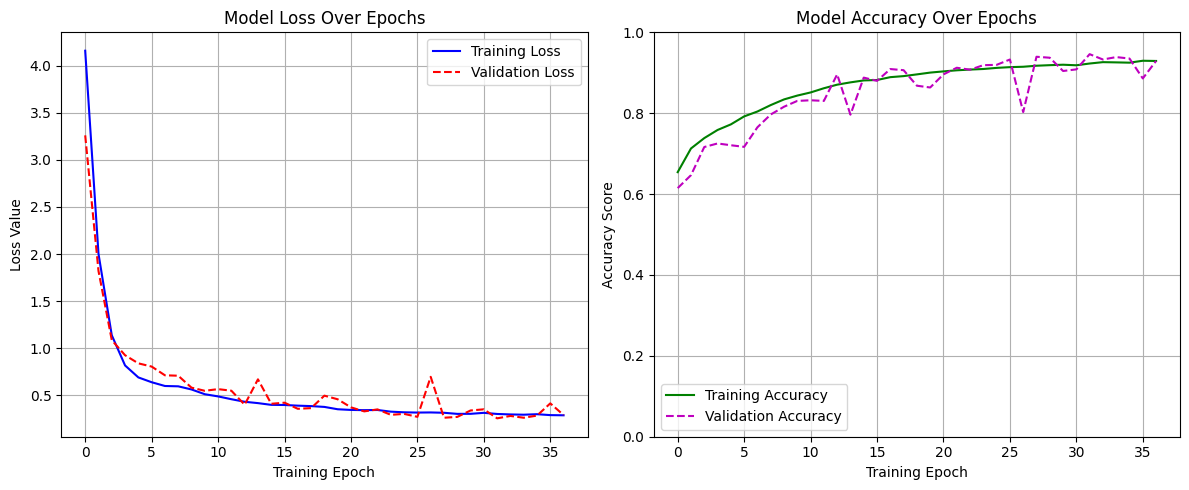

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert training history to DataFrame for easier manipulation
history_df = pd.DataFrame(history.history)

# Create figure with 2 subplots (side by side)
plt.figure(figsize=(12, 5))

# 1. Loss Subplot (Left)
plt.subplot(1, 2, 1)
plt.plot(history_df['loss'], 'b-', label='Training Loss')
plt.plot(history_df['val_loss'], 'r--', label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Training Epoch')
plt.ylabel('Loss Value')
plt.grid(True)
plt.legend()

# 2. Accuracy Subplot (Right)
plt.subplot(1, 2, 2)
plt.plot(history_df['accuracy'], 'g-', label='Training Accuracy')
plt.plot(history_df['val_accuracy'], 'm--', label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Training Epoch')
plt.ylabel('Accuracy Score')
plt.grid(True)
plt.ylim(0, 1)
plt.legend()

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()

* Sounds Good!
* We can go farther use More Epochs
* As we use ModelCheckpoint callback, the model will start from the final best weights stoed before

In [14]:
# Training Configuration With More Epochs
history = model.fit(
    train_generator,
    epochs=100,
    validation_data=val_generator,
    callbacks=callbacks,
    verbose=1
)

# Save Final Model 
model.save('/kaggle/working/output/dogs_vs_cats_model.h5')
print("Training completed and model saved in ")
!ls -lh /kaggle/working/output/

Epoch 1/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 126s 178ms/step - accuracy: 0.9275 - loss: 0.2905 - precision: 0.9283 - recall: 0.9282 - val_accuracy: 0.9412 - val_loss: 0.2237 - val_precision: 0.9554 - val_recall: 0.9256 - learning_rate: 5.0000e-05
Epoch 2/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 127s 179ms/step - accuracy: 0.9366 - loss: 0.2395 - precision: 0.9361 - recall: 0.9369 - val_accuracy: 0.9416 - val_loss: 0.2149 - val_precision: 0.9570 - val_recall: 0.9248 - learning_rate: 5.0000e-05
Epoch 3/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 126s 178ms/step - accuracy: 0.9312 - loss: 0.2399 - precision: 0.9311 - recall: 0.9320 - val_accuracy: 0.9320 - val_loss: 0.2347 - val_precision: 0.9712 - val_recall: 0.8904 - learning_rate: 5.0000e-05
Epoch 4/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 126s 177ms/step - accuracy: 0.9305 - loss: 0.2407 - precision: 0.9314 - recall: 0.9293 - val_accuracy: 0.9372 - val_loss: 0.2311 - val_precision: 0.9651 - val_recall: 0.9072 - learning_rate: 5.0000e-05
Epoch 5/100
704/704 ━━━━━━━━

In [15]:
# Evaluation
train_acc = model.evaluate(train_generator)[1]
valid_acc = model.evaluate(val_generator)[1]
print("Our New Model Accuracy on Training Data: ", train_acc)
print("Our New Model Accuracy on Validation Data: ", valid_acc)

704/704 ━━━━━━━━━━━━━━━━━━━━ 123s 174ms/step - accuracy: 0.9557 - loss: 0.1843 - precision: 0.9380 - recall: 0.9755
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.9408 - loss: 0.2296 - precision: 0.4215 - recall: 0.4961
Our New Model Accuracy on Training Data:  0.9557777643203735
Our New Model Accuracy on Validation Data:  0.9495999813079834


* Very Good

## Classification Matrics For Evulate our CNN Model

79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step


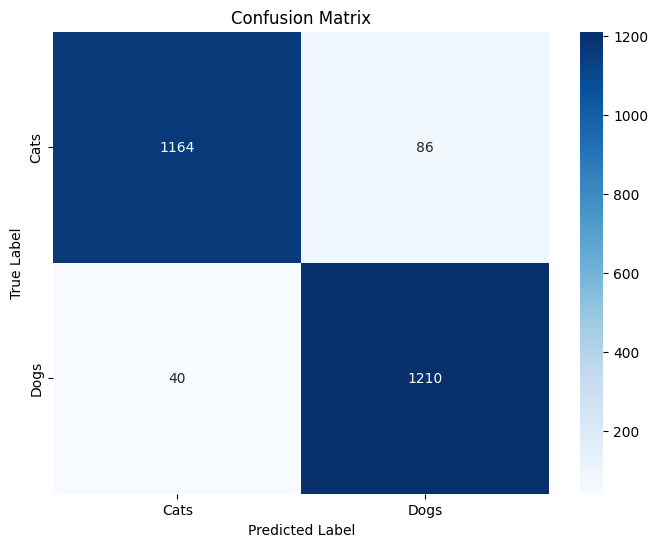


Detailed Classification Report:
              precision    recall  f1-score   support

        Cats       0.97      0.93      0.95      1250
        Dogs       0.93      0.97      0.95      1250

    accuracy                           0.95      2500
   macro avg       0.95      0.95      0.95      2500
weighted avg       0.95      0.95      0.95      2500


Final Validation Accuracy: 1250.0000


In [16]:
from sklearn.metrics import confusion_matrix, classification_report

# 1. Get model predictions
val_preds = model.predict(val_generator)
val_preds = (val_preds > 0.5).astype(int)  # Convert probabilities to binary predictions (0 or 1)

# 2. Get true labels
val_true = val_generator.classes

# 3. Generate Confusion Matrix
cm = confusion_matrix(val_true, val_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Cats', 'Dogs'],
            yticklabels=['Cats', 'Dogs'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# 4. Generate Classification Report
print("\nDetailed Classification Report:")
print(classification_report(val_true, val_preds,
                          target_names=['Cats', 'Dogs']))

# 5. Calculate Overall Accuracy
val_acc = np.sum(val_preds == val_true) / len(val_true)
print(f"\nFinal Validation Accuracy: {val_acc:.4f}")

In [17]:
# Load Our Model
from tensorflow.keras.models import load_model
model = load_model('/kaggle/working/output/dogs_vs_cats_model.h5')

## CNN Model Testing On data From Internet

In [18]:
import requests
from PIL import Image

def predict_from_url(image_url):
    try:
        # Download The Image From URL
        response = requests.get(image_url, stream=True)
        img = Image.open(response.raw)

        # Processing
        img = img.convert('RGB')
        img = img.resize((150, 150))
        img_array = np.array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)
        
        # Predicition
        pred = model.predict(img_array)[0][0]
        confidence = pred if pred > 0.5 else 1 - pred
        return {
            'prediction': 'Dog' if pred > 0.5 else 'Cat',
            'confidence': float(confidence * 100)
        }
    
    except Exception as e:
        return {'error': str(e)}

# The Link URL
url = "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQZ0L7ciOGctocVYVpcLUIxcjI5Or3tj-e_jQ&s"  
result = predict_from_url(url)

# Show Result
if 'error' in result:
    print(f"Error: {result['error']}")
else:
    print(f"Predicition: {result['prediction']}")
    print(f"confidence: {result['confidence']:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Predicition: Dog
confidence: 99.83%


* Nice!
* Let's try Transfer Learning

# Transfer Learning
* A technique where knowledge learned from a task is re-used in order to boost performance on a related task.
* The pre-trained models are usually trained on massive datasets that are a standard benchmark. The weights obtained from the models can be reused in other tasks.
* Transfer learning is particularly very useful when you have a small training dataset.

There are three ways to use a pre-trained model:

* Prediction.
* Feature Extraction.
* Fine-tuning.
> Here, we will use it for Feature Extraction

We will use pre-trained VGG16 model

In [19]:
# Import necessary libraries
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam

# 1. Load pre-trained VGG16 model (without top classification layer)
base_model = VGG16(
    weights='imagenet',  # Load weights pre-trained on ImageNet
    include_top=False,   # Exclude the original fully-connected layers
    input_shape=(150, 150, 3)  
)

# 2. Freeze all layers in the base model (they won't be trained)
for layer in base_model.layers:
    layer.trainable = False
print("VGG16 base model frozen (non-trainable)")

# 3. Build new model on top of VGG16
VGG16_model = Sequential([
    base_model,          # The pre-trained VGG16 feature extractor
    Flatten(),         
    Dense(256, activation='relu'), 
    Dropout(0.5),      
    Dense(1, activation='sigmoid')  
])
print("Custom classification head added")

# 4. Compile the model
VGG16_model.compile(
    optimizer=Adam(learning_rate=1e-4),  
     loss='binary_crossentropy',
              metrics=['accuracy',
                      tf.keras.metrics.Precision(),
                      tf.keras.metrics.Recall()]
)

# Display model architecture. See your dense network connected at the end.
VGG16_model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
VGG16 base model frozen (non-trainable)
Custom classification head added


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 4, 4, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │       2,097,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,812,353 (64.13 MB)

 Trainable params: 2,097,665 (8.00 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [20]:
# Declare Needed Callbacks Before Fitting
callbacks = [
    ModelCheckpoint(
        '/kaggle/working/output/vgg16_best_weights.weights.h5',
        monitor='val_accuracy',
        save_best_only=True,
        save_weights_only=True
    ),
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    )
]

# Training
VGG16_history = VGG16_model.fit(
    train_generator,
    steps_per_epoch=100,
    epochs=100,
    validation_data=val_generator,
    validation_steps=50
)

# Save our VGG16 Model
VGG16_model.save('/kaggle/working/output/vgg16_dogs_vs_cats_model.h5')
VGG16_model.save_weights('/kaggle/working/output/vgg16_dogs_vs_cats_weights.weights.h5')
print("Training completed and model saved in ")
!ls -lh /kaggle/working/output/

Epoch 1/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 29s 211ms/step - accuracy: 0.6394 - loss: 0.6231 - precision_1: 0.6398 - recall_1: 0.6191 - val_accuracy: 0.8769 - val_loss: 0.3135 - val_precision_1: 0.6696 - val_recall_1: 0.8629
Epoch 2/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 199ms/step - accuracy: 0.8341 - loss: 0.3711 - precision_1: 0.8363 - recall_1: 0.8218 - val_accuracy: 0.8633 - val_loss: 0.2905 - val_precision_1: 1.0000 - val_recall_1: 0.8633
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 19s 194ms/step - accuracy: 0.8395 - loss: 0.3535 - precision_1: 0.8455 - recall_1: 0.8389 - val_accuracy: 0.9287 - val_loss: 0.1915 - val_precision_1: 0.8882 - val_recall_1: 0.7714
Epoch 4/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 18s 178ms/step - accuracy: 0.8469 - loss: 0.3459 - precision_1: 0.8645 - recall_1: 0.8140 - val_accuracy: 0.8678 - val_loss: 0.2700 - val_precision_1: 1.0000 - val_recall_1: 0.8678
Epoch 5/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 198ms/step - accuracy: 0.8726 - loss: 0.2998 - precision_1: 0.8841 

In [21]:
# Evaluation
train_acc = VGG16_model.evaluate(train_generator)[1]
valid_acc = VGG16_model.evaluate(val_generator)[1]
print("VGG16 Model Accuracy on Training Data: ", train_acc)
print("VGG16 Model Accuracy on Validation Data: ", valid_acc)

704/704 ━━━━━━━━━━━━━━━━━━━━ 120s 170ms/step - accuracy: 0.9144 - loss: 0.2089 - precision_1: 0.8836 - recall_1: 0.9549
79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.9013 - loss: 0.2531 - precision_1: 0.3825 - recall_1: 0.4942
VGG16 Model Accuracy on Training Data:  0.9107111096382141
VGG16 Model Accuracy on Validation Data:  0.921999990940094


Not bad and we could go further with more epochs and more fine tuning but I'm going to go with our CNN model because it's good.

## Loss & Accuracy Plotting for VGG16 Model

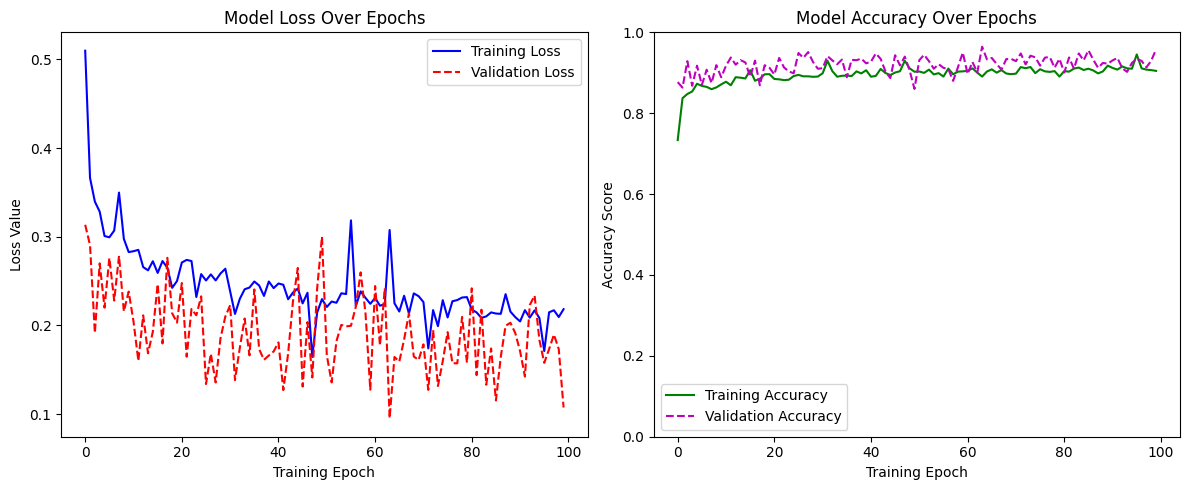

In [22]:
# Convert training history to DataFrame for easier manipulation
VGG16_history_df = pd.DataFrame(VGG16_history.history)

# Create figure with 2 subplots (side by side)
plt.figure(figsize=(12, 5))

# 1. Loss Subplot (Left)
plt.subplot(1, 2, 1)
plt.plot(VGG16_history_df['loss'], 'b-', label='Training Loss')
plt.plot(VGG16_history_df['val_loss'], 'r--', label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Training Epoch')
plt.ylabel('Loss Value')
plt.legend()

# 2. Accuracy Subplot (Right)
plt.subplot(1, 2, 2)
plt.plot(VGG16_history_df['accuracy'], 'g-', label='Training Accuracy')
plt.plot(VGG16_history_df['val_accuracy'], 'm--', label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Training Epoch')
plt.ylabel('Accuracy Score')
plt.ylim(0, 1)
plt.legend()

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()

## Classification Matrics For Evulate VGG16 Model

79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step


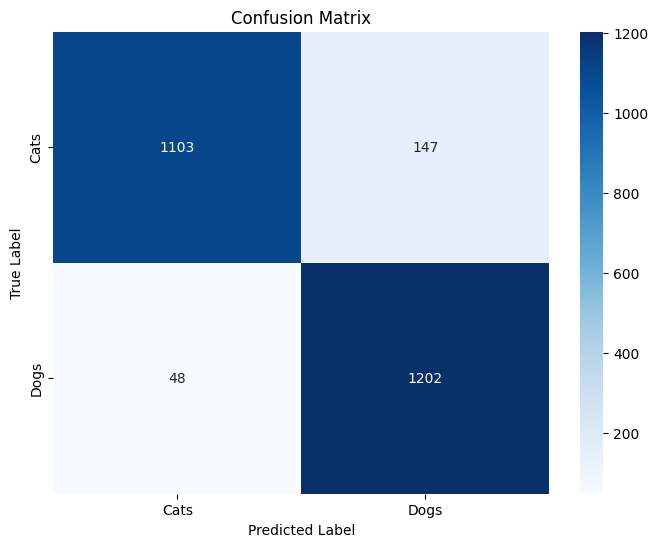


Detailed Classification Report:
              precision    recall  f1-score   support

        Cats       0.96      0.88      0.92      1250
        Dogs       0.89      0.96      0.92      1250

    accuracy                           0.92      2500
   macro avg       0.92      0.92      0.92      2500
weighted avg       0.92      0.92      0.92      2500


Final Validation Accuracy for VGG16 model: 1250.0000


In [23]:
# 1. Get model predictions
val_preds = VGG16_model.predict(val_generator)
val_preds = (val_preds > 0.5).astype(int)  # Convert probabilities to binary predictions (0 or 1)

# 2. Get true labels
val_true = val_generator.classes

# 3. Generate Confusion Matrix
cm = confusion_matrix(val_true, val_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Cats', 'Dogs'],
            yticklabels=['Cats', 'Dogs'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# 4. Generate Classification Report
print("\nDetailed Classification Report:")
print(classification_report(val_true, val_preds,
                          target_names=['Cats', 'Dogs']))

# 5. Calculate Overall Accuracy
val_acc = np.sum(val_preds == val_true) / len(val_true)
print(f"\nFinal Validation Accuracy for VGG16 model: {val_acc:.4f}")

* We will go wth The CNN Model because It's have a better performance

# Evaulate Our Best Model on Testing

In [25]:
# Extract the test zip file
test_zip_path = '/kaggle/input/dogs-vs-cats/test1.zip'
extract_path = '/kaggle/working/test_data'

# Create extraction directory if it doesn't exist
os.makedirs(extract_path, exist_ok=True)

# Unzip the test files
with zipfile.ZipFile(test_zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)
    
print(f"Test files extracted to: {extract_path}")

Test files extracted to: /kaggle/working/test_data


In [26]:
# Verify the extracted files
test_files = os.listdir(os.path.join(extract_path, 'test1'))
print(f"\nNumber of test images: {len(test_files)}")
print("First 5 files:", test_files[:5])


Number of test images: 12500
First 5 files: ['6660.jpg', '6390.jpg', '1430.jpg', '7133.jpg', '2853.jpg']


In [27]:
# Prepare ImageDataGenerator for test images
test_datagen = ImageDataGenerator(rescale=1./255)  # Normalize pixel values

test_generator = test_datagen.flow_from_directory(
    extract_path,               
    target_size=(150, 150),     
    batch_size=32,             
    class_mode=None,            
    shuffle=False               
)

Found 12500 images belonging to 1 classes.


In [ ]:
# Make predictions on test data
print("\nRunning predictions on test data...")
predictions = model.predict(test_generator)

# Convert probability predictions to labels
predicted_labels = ['dog' if pred > 0.5 else 'cat' for pred in predictions]

# Display random prediction samples
sample_indices = random.sample(range(len(predicted_labels)), 5)

print("\nRandom prediction samples:")
for idx in sample_indices:
    confidence = max(predictions[idx][0], 1-predictions[idx][0]) * 100
    print(f"Image: {test_generator.filenames[idx]} - Prediction: {predicted_labels[idx]} (Confidence: {confidence:.1f}%)")

Create DataFrame Similar to Submission CSV File

In [ ]:
# Save predictions for competition submission
submission = pd.DataFrame({
    'id': [os.path.splitext(f)[0] for f in test_generator.filenames],  # Remove file extension
    'label': [1 if pred > 0.5 else 0 for pred in predictions]  # 1=dog, 0=cat
})

submission_path = '/kaggle/working/output/test_predictions.csv'
submission.to_csv(submission_path, index=False)
print(f"\nPredictions saved to: {submission_path}")

Hossam Taha
* LinkedIn : https://linkedin.com/in/hossam-taha-41b724288